In [37]:
# Importing The required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# importing the data_set
data = pd.read_csv('../../../data/processed/fully_integrated_data.csv')
data.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

### Feature Selection

In [39]:
# Calculate performance metrics
data['position_change'] = data['driverStartGridPos'] - data['driverFinalRank']
data['percent_improvement'] = (data['position_change'] / data['driverStartGridPos']) * 100
data['overtakes'] = data.apply(lambda x: max(0, x['driverStartGridPos'] - x['driverFinalRank']), axis=1)
data['defended_position'] = data.apply(lambda x: 1 if x['driverStartGridPos'] >= x['driverFinalRank'] else 0, axis=1)

# Create comprehensive driver analysis
driver_performance = data.groupby('driverName').agg({
    'driverStartGridPos': ['mean', 'std'],      # Qualifying performance
    'driverFinalRank': ['mean', 'std'],         # Race performance
    'position_change': ['mean', 'std'],         # Position change consistency
    'percent_improvement': ['mean', 'std'],     # Improvement rate
    'overtakes': 'sum',                         # Total overtakes
    'defended_position': 'mean',                # Position defense rate
    'raceId': 'count'                          # Number of races
}).round(2)

# Flatten column names
driver_performance.columns = ['_'.join(col).strip() for col in driver_performance.columns]


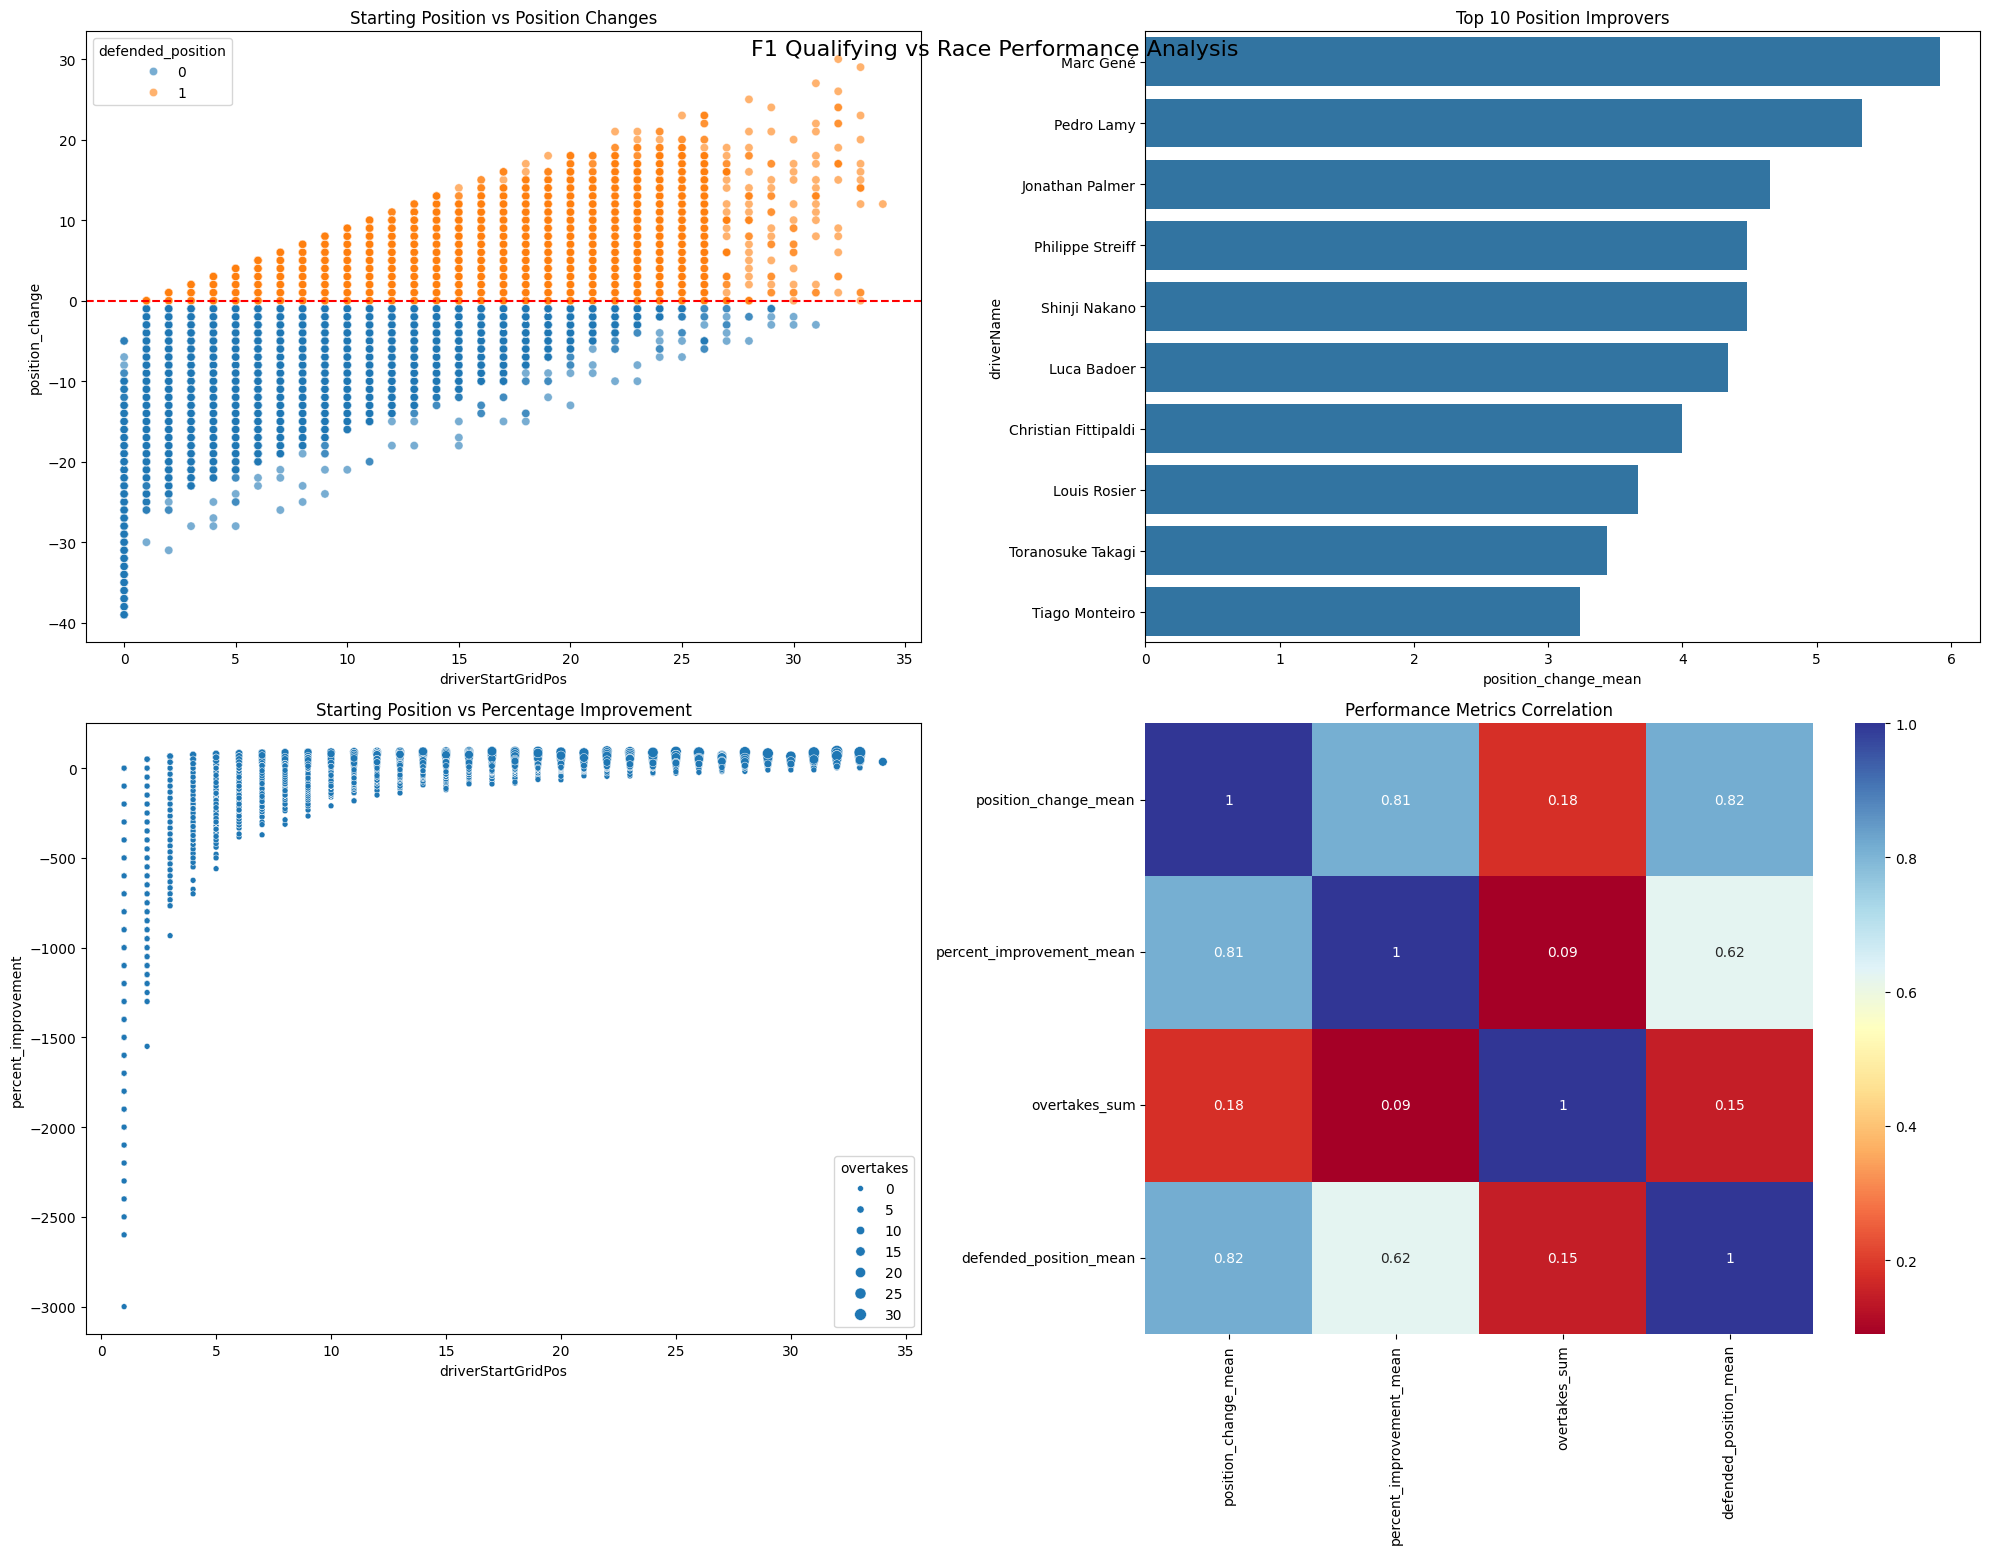


Qualifying vs Race Performance Analysis:

1. Top 5 Position Improvers:
                  position_change_mean  percent_improvement_mean  \
driverName                                                         
Marc Gené                         5.92                     28.41   
Pedro Lamy                        5.34                     27.87   
Jonathan Palmer                   4.65                      -inf   
Philippe Streiff                  4.48                     18.66   
Shinji Nakano                     4.48                     22.73   

                  overtakes_sum  
driverName                       
Marc Gené                   218  
Pedro Lamy                  185  
Jonathan Palmer             585  
Philippe Streiff            332  
Shinji Nakano               174  

2. Most Consistent Qualifiers vs Race Performance:
                driverStartGridPos_mean  driverStartGridPos_std  \
driverName                                                        
Max Chilton                

In [40]:
# Filter for drivers with minimum 30 races
driver_performance = driver_performance[driver_performance['raceId_count'] >= 30]

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
plt.suptitle('F1 Qualifying vs Race Performance Analysis', fontsize=16, y=0.95)

# 1. Position Changes Distribution
sns.scatterplot(data=data, 
                x='driverStartGridPos', 
                y='position_change',
                hue='defended_position',
                alpha=0.6,
                ax=axes[0,0])
axes[0,0].set_title('Starting Position vs Position Changes')
axes[0,0].axhline(y=0, color='r', linestyle='--')

# 2. Top Position Improvers
top_improvers = driver_performance.nlargest(10, 'position_change_mean')
sns.barplot(data=top_improvers,
            y=top_improvers.index,
            x='position_change_mean',
            ax=axes[0,1])
axes[0,1].set_title('Top 10 Position Improvers')

# 3. Percentage Improvement vs Starting Position
sns.scatterplot(data=data,
                x='driverStartGridPos',
                y='percent_improvement',
                size='overtakes',
                ax=axes[1,0])
axes[1,0].set_title('Starting Position vs Percentage Improvement')

# 4. Performance Correlation Matrix
performance_matrix = driver_performance[[
    'position_change_mean',
    'percent_improvement_mean',
    'overtakes_sum',
    'defended_position_mean'
]].corr()
sns.heatmap(performance_matrix,
            annot=True,
            cmap='RdYlBu',
            ax=axes[1,1])
axes[1,1].set_title('Performance Metrics Correlation')

plt.tight_layout()
plt.show()

# Print statistical insights
print("\nQualifying vs Race Performance Analysis:")
print("\n1. Top 5 Position Improvers:")
print(driver_performance.nlargest(5, 'position_change_mean')[[
    'position_change_mean', 
    'percent_improvement_mean',
    'overtakes_sum'
]])

print("\n2. Most Consistent Qualifiers vs Race Performance:")
consistency_matrix = driver_performance.nsmallest(5, 'driverStartGridPos_std')[[
    'driverStartGridPos_mean',
    'driverStartGridPos_std',
    'position_change_mean'
]]
print(consistency_matrix)

print("\n3. Starting Position Impact:")
pos_change_corr = data['driverStartGridPos'].corr(data['position_change'])
print(f"Correlation between starting position and position change: {pos_change_corr:.3f}")

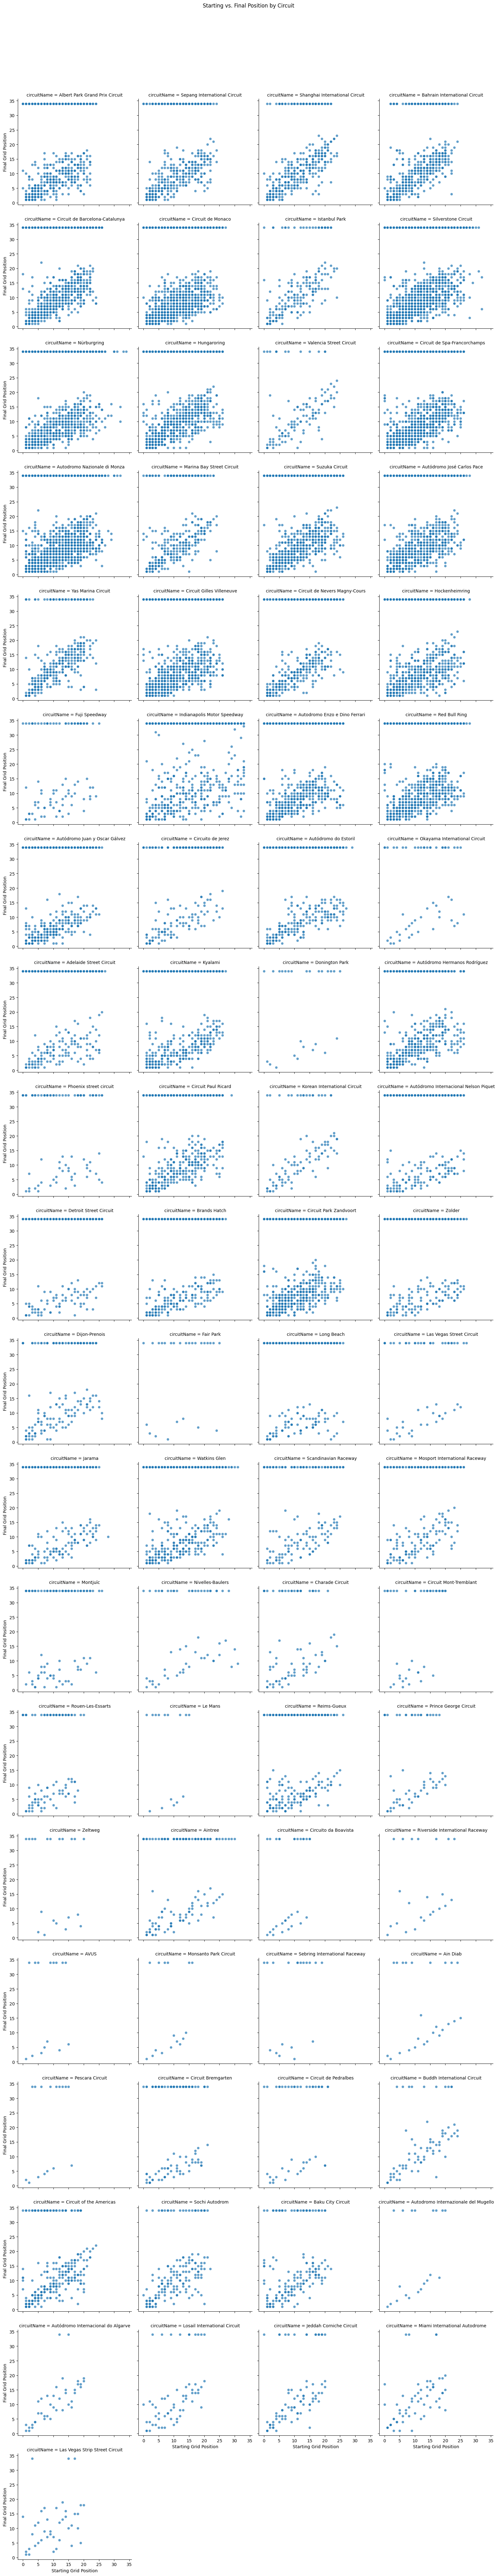

In [41]:
avg_position_change = data.groupby('driverId')['position_change'].mean().reset_index()
avg_position_change.columns = ['driverId', 'avgPositionGain']
grid_positions = data['driverStartGridPos'].unique()
grouped_final_positions = [data[data['driverStartGridPos'] == pos]['driverFinalGridPos'] for pos in grid_positions]

g = sns.FacetGrid(
    data=data,
    col="circuitName",     # Create a separate subplot for each circuit
    col_wrap=4,            # How many plots per row
    height=4,              # Height of each subplot
    aspect=1
)

g.map_dataframe(
    sns.scatterplot,
    x="driverStartGridPos",
    y="driverFinalGridPos",
    alpha=0.7
)

g.set_axis_labels("Starting Grid Position", "Final Grid Position")
g.fig.suptitle("Starting vs. Final Position by Circuit", y=1.03)
plt.tight_layout()
plt.show()

In [42]:

import statsmodels.api as sm
from statsmodels.formula.api import ols


# driverFinalGridPos ~ driverStartGridPos + circuitId
model_ancova = ols("driverFinalGridPos ~ driverStartGridPos + C(circuitId)", data=data).fit()
ancova_table = sm.stats.anova_lm(model_ancova, typ=2)
ancova_table



,sum_sq,df,F,PR(>F)
C(circuitId),1.622117e+05,76.0,12.756820,8.241974e-152
driverStartGridPos,1.092338e+05,1.0,652.876558,2.725949e-142
Residual,4.464041e+06,26681.0,NaN,NaN


##### Does the relationship (slope) between final and starting positions differ by circuit?

In [43]:
model_interact = ols("driverFinalGridPos ~ driverStartGridPos * C(circuitId)", data=data).fit()
interaction_table = sm.stats.anova_lm(model_interact, typ=2)
interaction_table

,sum_sq,df,F,PR(>F)
C(circuitId),1.622117e+05,76.0,12.914098,4.079688e-154
driverStartGridPos,1.092338e+05,1.0,660.925811,5.394919e-144
driverStartGridPos:C(circuitId),6.692727e+04,76.0,5.328256,6.214582e-46
Residual,4.397114e+06,26605.0,NaN,NaN


In [45]:
# Suppose we build multiple reference start positions or replicate data
from statsmodels.stats.multicomp import pairwise_tukeyhsd
start_positions = np.linspace(data['driverStartGridPos'].min(), data['driverStartGridPos'].max(), 5)
circuits = data['circuitId'].unique()
# For each circuit and each start pos, predict final pos
rows = []
for circuit in circuits:
    for sp in start_positions:
        pred = model.predict(pd.DataFrame({
            'driverStartGridPos': [sp],
            'circuitId': [circuit]
        }))
        rows.append({'circuitId': circuit, 'startPos': sp, 'predictedFinalPos': pred.values[0]})

predictions_df = pd.DataFrame(rows)

# Now you have multiple predictions per circuit; you can do a pairwise test:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=predictions_df['predictedFinalPos'], 
    groups=predictions_df['circuitId'], 
    alpha=0.05
)
print(tukey)


NameError: name 'model' is not defined

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("driverFinalGridPos ~ driverStartGridPos + C(circuitId)", data=data).fit()
circuits = data['circuitId'].unique()
mean_start_pos = data['driverStartGridPos'].mean()

# Build a small "prediction" DataFrame
pred_data = pd.DataFrame({
    'driverStartGridPos': [mean_start_pos]*len(circuits),
    'circuitId': circuits
})
pred_data['predictedFinalPos'] = model.predict(pred_data)

NameError: name 'df' is not defined

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=pred_data, x='circuitId', y='predictedFinalPos', color='skyblue')
plt.title('Predicted Final Position at Average Start Position (by Circuit)')
plt.xlabel('Circuit')
plt.ylabel('Predicted Final Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()